In [1]:
import sys

codefolder = "C:/ProjectCollections/Programs/Australia_Cultural_Data_Engine/codes"

sys.path.append(codefolder)
import os
import pprint
from collections import defaultdict

import matplotlib.colors as colors
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from acde import MongoDBManipulation as acde_manip
from general import GeneralFunctions as gen_gf
from general import JsonProcessing as gen_jp
from general import MongoDBManipulation as gen_manip
from tqdm import tqdm

pp = pprint.PrettyPrinter(indent=2)
acde_opr = acde_manip.ACDE_Manipulation()

In [2]:
coll_doc_counter = {}

print("The Australian Cultural Data Engine Database has following collections:")
for coll_name in acde_opr.acde_db.list_collection_names():
    coll_doc_counter[coll_name] = list(
        acde_opr.acde_db[coll_name].aggregate(
            [{"$group": {"_id": "$data_source", "count": {"$sum": 1}}}]
        )
    )
    print(
        f"- {coll_name} collection: {acde_opr.acde_db[coll_name].count_documents({})} records."
    )

The Australian Cultural Data Engine Database has following collections:
- work collection: 45904 records.
- recognition collection: 5498 records.
- place collection: 30631 records.
- event collection: 147234 records.
- resource collection: 144335 records.
- organization collection: 21790 records.
- relationship collection: 1937075 records.
- person collection: 203803 records.


,Data Source,Level,#Doc
0,DAQA,work,2203.0
1,DAAO,work,23729.0
2,AusStage,work,19972.0
3,CircusOZ,work,NaN
4,SFC,work,NaN
5,DAQA,recognition,27.0
6,DAAO,recognition,5471.0
7,AusStage,recognition,NaN
8,CircusOZ,recognition,NaN
9,SFC,recognition,NaN


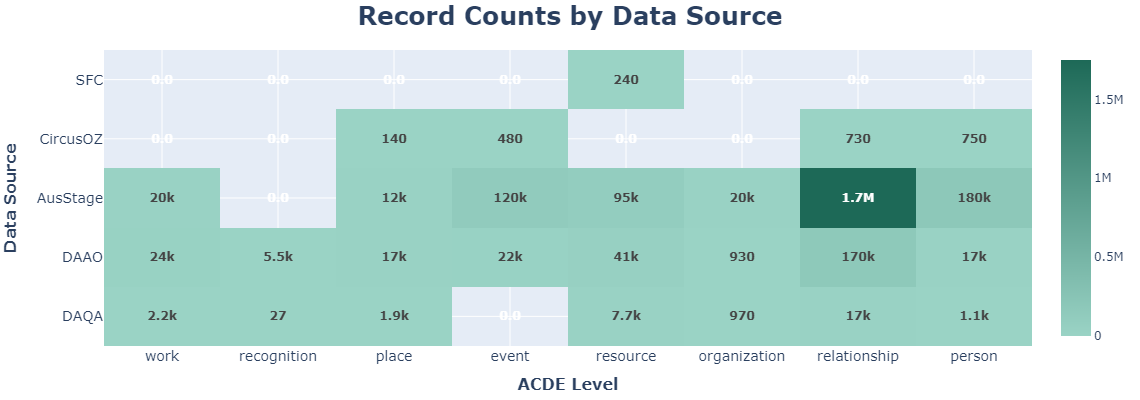

In [7]:
# convert the data into a dataframe
coll_doc_df = (
    pd.DataFrame(
        {k: {d["_id"]: d["count"] for d in v} for k, v in coll_doc_counter.items()}
    )
    .reset_index()
    .melt(
        id_vars=["index"],
        value_vars=coll_doc_counter.keys(),
        var_name="Level",
        value_name="#Doc",
    )
    .rename({"index": "Data Source"}, axis=1)
)

display(coll_doc_df)


# set theme color scale
start_color = "#9AD3C5"
end_color = "#1D6957"
n_colors = 800  # number of colors in the scale

# Convert colors to RGB tuples
start_rgb = colors.hex2color(start_color)
end_rgb = colors.hex2color(end_color)

# Generate the list of colors
colorscales = []
for i in range(n_colors):
    c = tuple(
        (1 - i / (n_colors - 1)) * start_rgb[j] + (i / (n_colors - 1)) * end_rgb[j]
        for j in range(3)
    )
    colorscales.append(colors.rgb2hex(c))

# Create the heatmap
heatmap = go.Heatmap(
    z=coll_doc_df["#Doc"],
    y=coll_doc_df["Data Source"],
    x=coll_doc_df["Level"],
    text=coll_doc_df["#Doc"],
    colorscale=colorscales,
    texttemplate="<b>%{z:.2s}</b>",
    hovertemplate="<b>%{y}</b> in <b>%{x}</b>: %{z:.0f}<extra></extra>",
)

# Define the layout
layout = go.Layout(
    title={
        "text": "<b>Record Counts by Data Source</b>",
        "font": {"size": 25},
        "x": 0.5,
    },
    xaxis=dict(
        title="<b>ACDE Level</b>", title_font=dict(size=16), tickfont=dict(size=14),
    ),
    yaxis=dict(
        title="<b>Data Source</b>", title_font=dict(size=16), tickfont=dict(size=14),
    ),
    width=1200,
    height=400,
    margin=dict(l=50, r=50, t=50, b=10),
)

# Create the figure
coll_doc_fig = go.Figure(data=[heatmap], layout=layout)

# Show the figure
coll_doc_fig.show()

In [4]:
relat_cls_counter = list(
    acde_opr.acde_db["relationship"].aggregate(
        [{"$group": {"_id": ["$data_source", "$relation_class"], "count": {"$sum": 1}}}]
    )
)
relat_cls_df = pd.DataFrame(relat_cls_counter)
relat_cls_df[["data_source", "relation_class"]] = relat_cls_df["_id"].apply(pd.Series)
relat_cls_df = relat_cls_df.drop("_id", axis=1).sort_values(
    ["relation_class", "data_source", "count"], ascending=[False, True, False]
)

display(relat_cls_df)

,count,data_source,relation_class
51,240,AusStage,Work_RelatedWork
16,4084,DAAO,Work_RelatedResource
28,4889,DAQA,Work_RelatedResource
33,27,DAAO,Work_RelatedRecognition
37,1,DAQA,Work_RelatedRecognition
43,11,DAAO,Work_RelatedPlace
9,1843,DAQA,Work_RelatedPlace
52,22235,AusStage,Work_RelatedPerson
14,31,DAQA,Work_RelatedPerson
32,1185,AusStage,Work_RelatedOrganization


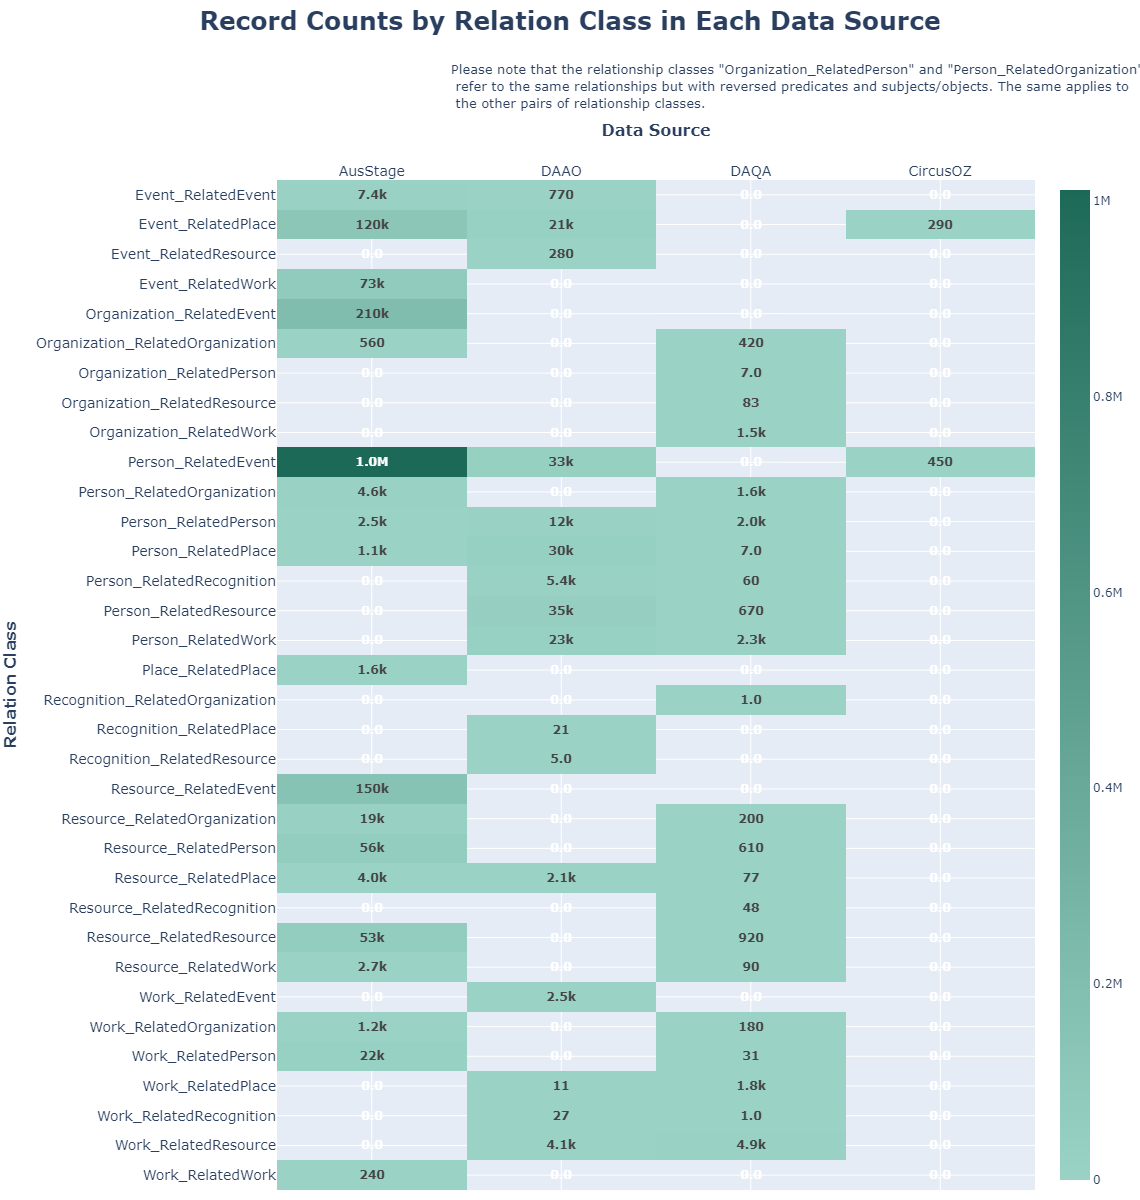

In [5]:
# Create the heatmap
heatmap = go.Heatmap(
    z=relat_cls_df["count"],
    y=relat_cls_df["relation_class"],
    x=relat_cls_df["data_source"],
    text=relat_cls_df["count"],
    colorscale=colorscales,
    texttemplate="<b>%{z:.2s}</b>",
    hovertemplate="<b>%{y}</b> in <b>%{x}</b>: %{z:.0f}<extra></extra>",
)

# Define the layout
layout = go.Layout(
    title={
        "text": "<b>Record Counts by Relation Class in Each Data Source</b>",
        "font": {"size": 25},
        "x": 0.5,
        "y": 0.99,
    },
    xaxis=dict(
        title="<b>Data Source</b>",
        title_font=dict(size=16),
        tickfont=dict(size=14),
        side="top",
    ),
    yaxis=dict(
        title="<b>Relation Class</b>", title_font=dict(size=16), tickfont=dict(size=14),
    ),
    width=800,
    height=1200,
    margin=dict(l=50, r=50, t=180, b=10),
)

# Create the figure
rc_fig = go.Figure(data=[heatmap], layout=layout)

rc_fig.add_annotation(
    text="""Please note that the relationship classes "Organization_RelatedPerson" and "Person_RelatedOrganization" <br>
refer to the same relationships but with reversed predicates and subjects/objects. The same applies to<br>
the other pairs of relationship classes.""",
    xref="paper",
    yref="paper",
    align="left",
    x=1.15,
    y=1.12,
    font=dict(size=13),
    showarrow=False,
)

# Show the figure
rc_fig.show()

In [6]:
# Export the chart
coll_doc_fig.write_image(
    "../../images/ACDE_collection_summary.png", scale=3
)
rc_fig.write_image(
    "../../images/ACDE_relation_class_summary.png", scale=3
)